### Algoritmo para classificar sensibilidades

#### Importando as bibliotecas

In [47]:
# tratamento dos dados
import pandas as pd
import numpy as np

# plot dos gráficos
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# algoritmo de agrupamento
from sklearn.cluster import KMeans, DBSCAN

# feature engineering
from sklearn.preprocessing import StandardScaler

# avaliacao do desempenho
from sklearn.metrics import silhouette_score, adjusted_rand_score

#### Carregando os dados

In [18]:
dados = pd.read_excel(r'D:\Documentos\Projetos\Modelo cluster sensibilidade\Dados\dados_produtos.xls', decimal=',')

#### Limpeza dos dados

In [19]:
dados.head(2)

,Código Barras SKU,Nome SKU,Marca SKU,Fabricante SKU,.Cesta,.Categoria,.Sub-Categoria,Ranking na Categoria Grupo,Ranking na Categoria Mercado,Share Sku Grupo na Categoria,...,Decil Mercado (Cesta),Valor Produto Grupo (6M),Valor Produto Mercado (6M),Giro unitario por loja Grupo PF,Giro unitario por loja Mercado PF,Preço médio Grupo PF,Preço médio Mercado PF,Indice de Preço PF,% PDVs Grupo PF,% PDVs Mercado PF
0,7893000005945,FILE PEITO FRANGO SADIA 1KG ZIP,SADIA,BRF,ACOUGUE,AVE,AUTO SERVICO CONGELADO,1.0,1.0,0.0715,...,1,1.325676e+06,1.227136e+06,748.0,673.0,15.12,16.27,0.929,1.0,0.90
1,7893000516083,FILEZINHO SASSAMI IQF SADIA PACOTE 1KG /42609,SADIA,BRF,ACOUGUE,AVE,AUTO SERVICO CONGELADO,2.0,2.0,0.0715,...,2,1.325676e+06,1.018304e+06,780.0,608.0,14.49,15.68,0.924,1.0,0.86


In [20]:
# tamanho do df
dados.shape

(62148, 30)

In [21]:
# verificando as colunas
print(dados.columns)

Index(['Código Barras SKU', 'Nome SKU', 'Marca SKU', 'Fabricante SKU',
       '.Cesta', '.Categoria', '.Sub-Categoria',
       'Ranking na Categoria Grupo   ', 'Ranking na Categoria Mercado   ',
       'Share Sku Grupo na Categoria', 'Share Sku Mercado na Categoria',
       'Share Acc Categoria Grupo', 'Share Acc Categoria Mercado',
       'Decil Grupo (Categoria)', 'Decil Mercado (Categoria)',
       'Share Sku Grupo na Cesta', 'Share Sku Mercado na Cesta',
       'Share Acc Cesta Grupo', 'Share Acc Cesta Mercado',
       'Decil Grupo\n(Cesta)', 'Decil Mercado (Cesta)',
       'Valor Produto Grupo (6M)', 'Valor Produto Mercado (6M)',
       'Giro unitario por loja Grupo PF', 'Giro unitario por loja Mercado PF',
       'Preço médio Grupo PF', 'Preço médio Mercado PF', 'Indice de Preço PF',
       '% PDVs Grupo PF', '% PDVs Mercado PF'],
      dtype='object')


In [22]:
# selecionando as colunas
dados = dados[['Código Barras SKU', 'Nome SKU', '.Cesta', 'Share Sku Grupo na Cesta', 'Share Sku Mercado na Cesta']]

In [25]:
# verificando os dados nulos
dados.isnull().sum()

Código Barras SKU                 0
Nome SKU                          0
.Cesta                            0
Share Sku Grupo na Cesta      47365
Share Sku Mercado na Cesta     6136
dtype: int64

In [34]:
# verificando quantidade de dados que tem dados em ambas as colunas, pois no df principal tem 62.148 linhas
dados[(dados['Share Sku Grupo na Cesta'].notnull()) & (dados['Share Sku Mercado na Cesta'].notnull())].count()

Código Barras SKU             10604
Nome SKU                      10604
.Cesta                        10604
Share Sku Grupo na Cesta      10604
Share Sku Mercado na Cesta    10604
dtype: int64

In [37]:
# removendo os valores nulos
dados.dropna(inplace=True)

In [40]:
# tipos de dados
dados.dtypes

Código Barras SKU               int64
Nome SKU                       object
.Cesta                         object
Share Sku Grupo na Cesta      float64
Share Sku Mercado na Cesta    float64
dtype: object

#### Análise exploratória dos dados

In [39]:
dados.describe()

,Código Barras SKU,Share Sku Grupo na Cesta,Share Sku Mercado na Cesta
count,1.060400e+04,10604.000000,10604.000000
mean,7.630491e+12,0.001269,0.000796
std,1.285187e+12,0.005130,0.002798
min,4.211020e+07,0.000000,0.000000
25%,7.891097e+12,0.000100,0.000100
50%,7.896009e+12,0.000300,0.000200
75%,7.896832e+12,0.000800,0.000600
max,1.789822e+13,0.284600,0.083000


Verificando a correlação das variáveis

<Axes: >

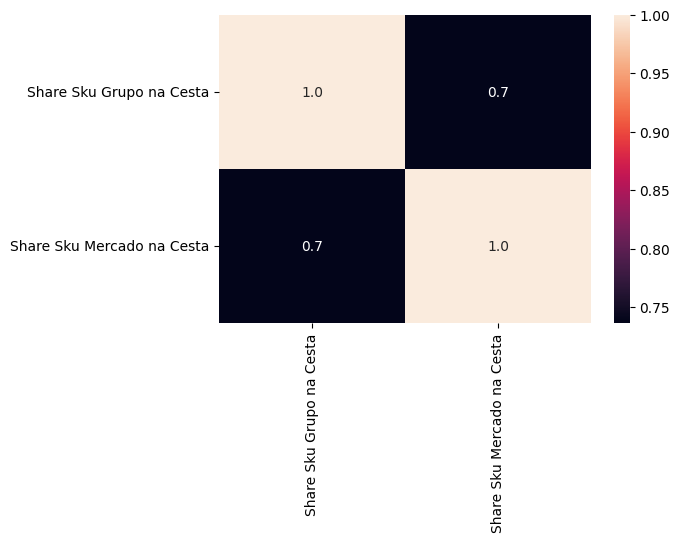

In [42]:
plt.figure(figsize=(6, 4))
sns.heatmap(dados[['Share Sku Grupo na Cesta', 'Share Sku Mercado na Cesta']].corr(method='pearson'), annot=True, fmt='.1f')

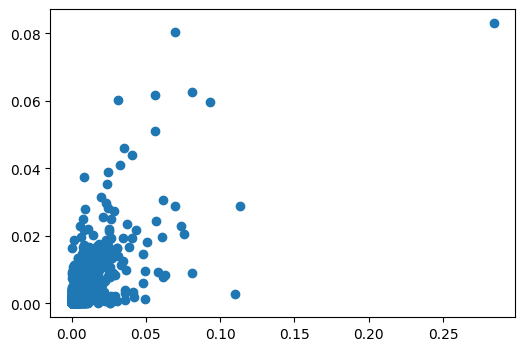

In [45]:
plt.figure(figsize=(6, 4))
plt.scatter(dados['Share Sku Grupo na Cesta'], dados['Share Sku Mercado na Cesta'])
plt.show()

#### Feature Scalling

Verificando a necessidade de utilizar a padronização ou normalização dos dados.

In [54]:
# padronizando as escalas
scaler = StandardScaler()
dados_scaled = scaler.fit_transform(dados[['Share Sku Grupo na Cesta', 'Share Sku Mercado na Cesta']])

dados_scaled = pd.DataFrame(dados_scaled, columns=['Share Sku Grupo na Cesta', 'Share Sku Mercado na Cesta'])

#### Criando os modelos

K-Means

- Escolhendo a quantidade de clusters a utilizar no modelo

In [56]:
# lista com quantidade de clusters que serão testados
k = list(range(1, 10))
print(k)

[1, 2, 3, 4, 5, 6, 7, 8, 9]


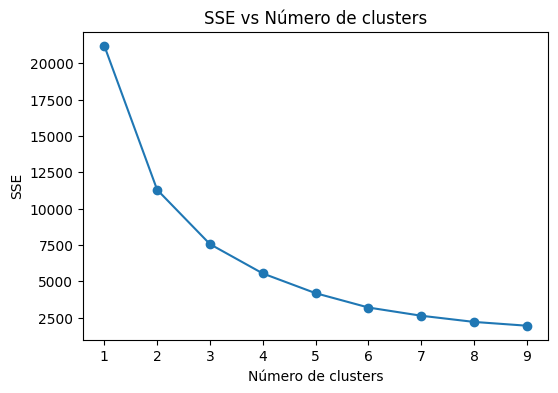

In [57]:
# armazenando SSE (soma dos erros quadrático) para cada valor de k
sse = []

# rodando o kmeans para cada valor de k
for i in k:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(dados_scaled)
    sse.append(kmeans.inertia_) # inertia_ é o SSE

# potando o gráfico
plt.figure(figsize=(6, 4))
plt.plot(k, sse, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.title('SSE vs Número de clusters')
plt.show()
